# Calculator

In [515]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections


# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

from PIL import Image
import sys
from sklearn.cluster import KMeans

import PIL
import math
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [61]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

In [62]:

def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)

In [485]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for contour in contours:        
        center, size, angle = cv2.minAreaRect(contour)
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        #  if (h < 10 and w > 10) or (w < 20 and h > 30) or (h > 20 and w > 20) or (h > 15  and h < 25)
        area = cv2.contourArea(contour)
        if area > 100 and h < 100:
             if (h < 10 and w > 10) or (w < 20 and h > 30) or (h > 20 and w > 20) or (h > 15  and h < 25):
                # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
                # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
                region = image_bin[y:y+h+1,x:x+w+1];
                regions_dic[x] = resize_region(region) 
                cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),1)
            
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions

In [457]:
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255


In [65]:
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()


In [66]:
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

In [67]:
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)


In [402]:
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(18, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=2000, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [69]:
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]


In [70]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

In [426]:
#COLOR IMAGE
image = cv2.imread('images/kalkulator_alfabet_zagrade.png') # ucitavanje slike sa diska
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (jer OpenCV ucita sliku kao BGR)
#print image.shape # ispis velicine slike
#display_image(image)

In [427]:
#GRAY_IMAGE
img_gray=image_gray(image)
#display_image(img_gray)

In [428]:
#BIN_IMAGE
img_bin=image_bin(img_gray)
#display_image(img_bin)

In [429]:
#INVERTED IMAGE
img_invert=invert(img_bin)
#display_image(img_invert)

In [430]:
img=erode(dilate(img_invert))
#display_image(img)

18


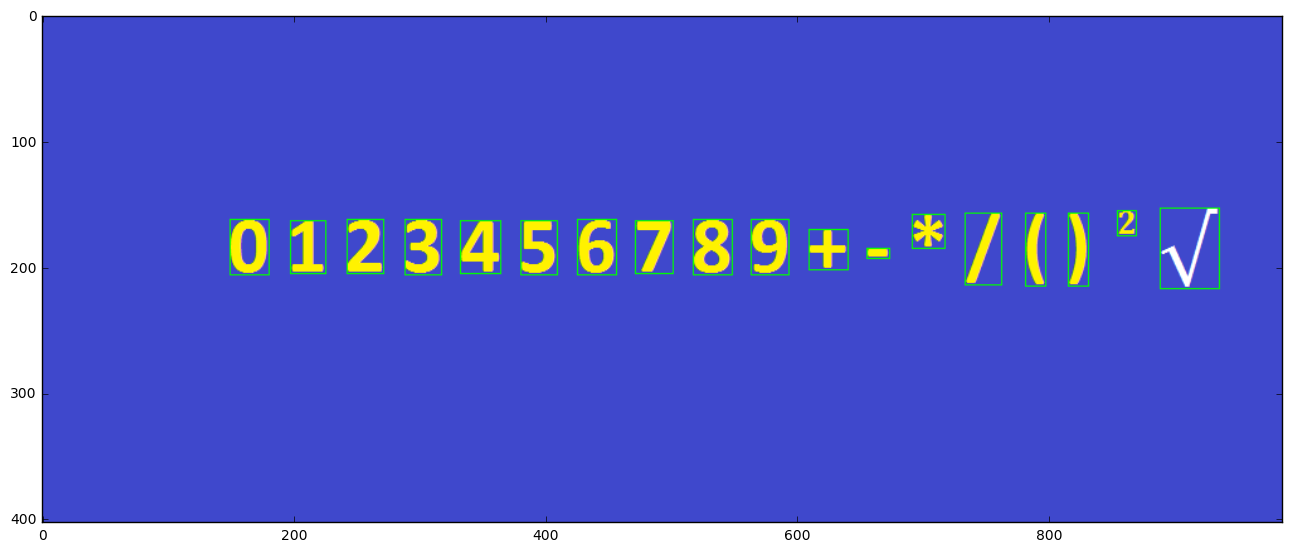

In [486]:
#SELECTED REGIONS
selected_regions, numbers = select_roi(image.copy(), img_invert)
display_image(selected_regions)
print(len(numbers))

In [494]:
# insert alphabet here
alphabet = [0,1,2,3,4,5,6,7,8,9,'+','-','*','/','(',')', '^', 's']


In [495]:
inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann()

In [496]:

ann = train_ann(ann, inputs, outputs)

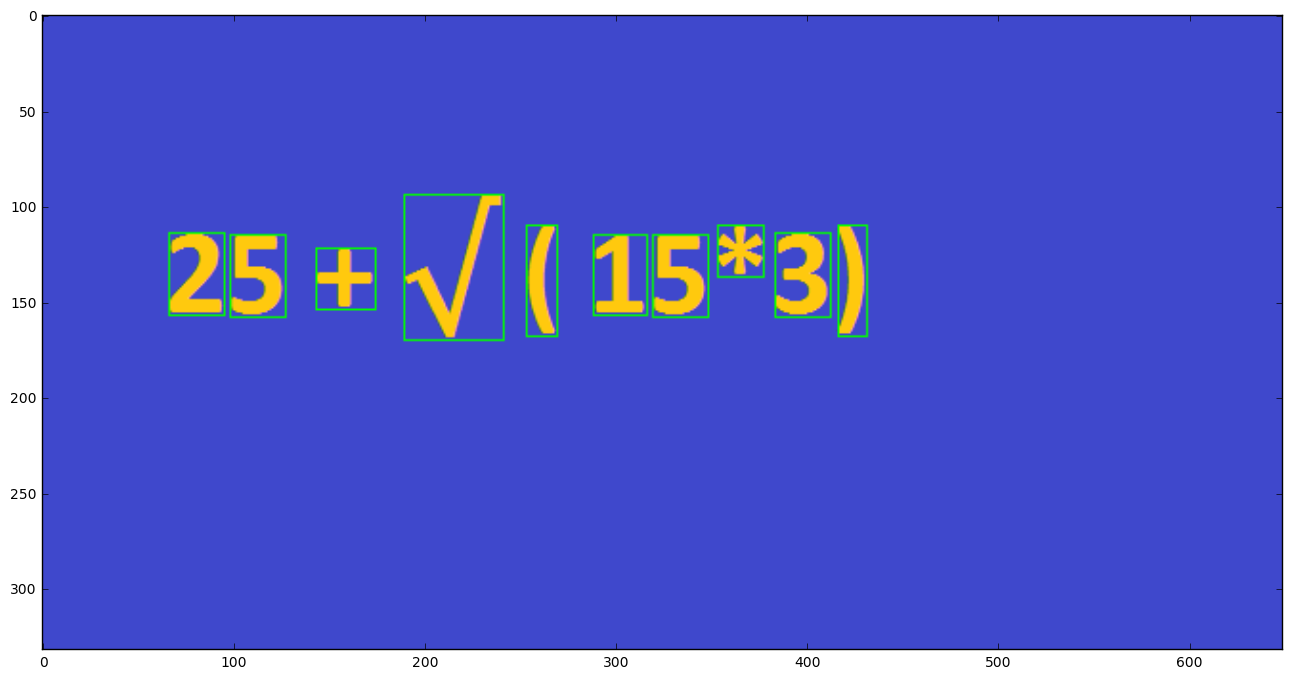

In [569]:
test_color = load_image('images/primer25.png')
test = invert(image_bin(image_gray(test_color)))
test_bin = erode(dilate(test))
selected_test, test_numbers = select_roi(test_color.copy(),test_bin)
display_image(selected_test)
test_inputs = prepare_for_ann(test_numbers)
result = ann.predict(np.array(test_inputs, np.float32))

In [570]:
res = display_result(result, alphabet)
print res

[2, 5, '+', 's', '(', 1, 5, '*', 3, ')']


In [577]:
def totalCalculate(function):
    calculated=0
    if(('*' in function) or ('/' in function) or ('s' in function)):
        return calculate(function)
    else:
        calculated=function[0]
        for index,letter in enumerate(function):
            if(letter=='+'):
                calculated=calculated+function[index+1]
            elif(letter=='-'):
                calculated=calculated-function[index+1]
    return calculated

In [578]:
def isBracket(index, function):
    if(function[index-1]=='(' or function[index+1]=='(' or function[index-1]==')' or function[index+1]==')'
      or function[index+1]=='s'):
        return True
    else:
        return False

In [579]:
def calculate(function):
    calculated=0
    newFunction=[]
    openedBracket=False
    inBrackets=[]
    bracketCounter=0
    
    for index,letter in enumerate(function):
        if(openedBracket==False):
            if(letter=='/'):
                if(isBracket(index,function) == False):
                    res=float(function[index-1])/function[index+1]
                    newFunction.append(res)
                else:
                    newFunction.append(letter)
            elif(letter=='*'):
                if(isBracket(index,function) == False):
                    res=float(function[index-1])*function[index+1]
                    newFunction.append(res)
                else:
                    newFunction.append(letter)
            elif(letter=='s'):
                if(isBracket(index,function) == False):
                    res=math.sqrt(function[index+1])
                    newFunction.append(res)
                else:
                    newFunction.append(letter)
            elif(letter=='+' or letter=='-'):
                newFunction.append(letter)
            elif(letter=='('):
                openedBracket=True;
            else:                                                                  #ako je broj
                if(index==0):                                                      #ako je prvi element
                    if(function[index+1]=='+' or function[index+1]=='-'):              #ako je znak posle prvog elementa + ili -
                        newFunction.append(letter)                                 #dodaj taj broj
                elif(index==len(function)-1):                                      #ako je zadnji element
                    if(function[index-1]=='+' or function[index-1]=='-'):              #ako je znak pre poslednjeg elementa + ili -
                        newFunction.append(letter)                                 #dodaj taj broj
                else:
                    if((function[index+1]=='+' or function[index+1]=='-')
                       and (function[index-1]=='+' or function[index-1]=='-')):        #ako je znak pre i posle + ili -, dodaj broj
                        newFunction.append(letter)
                    if(function[index+2]=='(' or function[index-2]==')' or function[index+2]=='s'):
                        newFunction.append(letter)
                    
        else:
            if(letter=='('):
                inBrackets.append(letter)
                bracketCounter = bracketCounter + 1
            elif(letter==')'):
                if(bracketCounter==0):
                    newFunction.append(calculate(inBrackets))
                    inBrackets=[]
                    openedBracket=False
                else:
                    inBrackets.append(letter)
                    bracketCounter = bracketCounter - 1
            else:
                inBrackets.append(letter)
           
    return totalCalculate(newFunction) 
    

In [580]:
def checkLetters(function):
    newFunction=[]
    counter=1
    for index,letter in enumerate(function):
        if counter == 1:
            if checkNumber(letter):
                isNumber=True
                numbers=[]
                numbers.append(letter)
                while(isNumber):
                    if(((index+counter) < len(function)) and checkNumber(function[index+counter])):
                        numbers.append(function[index+counter])
                        counter = counter + 1
                    else:
                        isNumber=False
                        
                tempCounter=counter
                tempNumber=0
                while(tempCounter!=0):
                    tempNumber  = tempNumber + function[index+counter-tempCounter] * 10**(tempCounter-1)
                    tempCounter = tempCounter-1
                newFunction.append(tempNumber)
            else:
                newFunction.append(letter)
        else:
            counter = counter-1
    return newFunction

In [581]:
def checkNumber(letter):
    if(letter!="+" and letter!="-" and letter!="/" and letter!="*" and letter!="(" and letter!=")"
       and letter!="s" and letter!="^"):
        return True
    else:
        return False

In [582]:
res = checkLetters(res)
returnValue=calculate(res)
print returnValue

31.7082039325
